In [ ]:
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.2.4

! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite


     |████████████████████████████████| 411.5 MB 6.6 kB/s 
     |████████████████████████████████| 3.8 MB 39.9 MB/s 
     |████████████████████████████████| 503 kB 44.4 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=26e24d75fe3bf0e0232e088e2c373ea7e69eab8daea11306a8e06ee1f29ab534
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import os
from shutil import copyfile, rmtree
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm


def load_data(data_folder, propaganda_techniques_file):
    file_list = glob.glob(os.path.join(data_folder, "*.txt"))
    articles_content, articles_id = ([], [])
    for filename in sorted(file_list):
        with open(filename, "r", encoding="utf-8") as f:
            articles_content.append(f.read())
            articles_id.append(os.path.basename(filename).split(".")[0][7:])

    with open(propaganda_techniques_file, "r") as f:
        propaganda_techniques_names = [line.rstrip() for line in f.readlines()]
    
    return articles_content, articles_id, propaganda_techniques_names


def read_predictions_from_file(filename):
    articles_id, gold_spans = ([], [])
    with open(filename, "r") as f:
        for row in f.readlines():
            article_id, gold_span_start, gold_span_end = row.rstrip().split("\t")
            articles_id.append(article_id)
            gold_spans.append(tuple(int(el) for el in [gold_span_start, gold_span_end]))
    return articles_id, gold_spans


def group_spans_by_article_ids(span_list):
    data = {}
    for el in span_list:
        article_id, span = el[0], el[1]
        data.setdefault(article_id, [])
        data[article_id].append(span)
    return data


def get_train_dev_files(articles_id, articles_content, nlp, labels_path, train_file, dev_file, split_by_ids=True, 
                     dev_size=0.3, random_state=42):
    articles_content_dict = dict(zip(articles_id, articles_content))
    articles_id, gold_spans = read_predictions_from_file(labels_path)
    span_list = list(zip(articles_id, gold_spans))
    
    if split_by_ids:
        data = group_spans_by_article_ids(span_list)
        train_ids, dev_ids = train_test_split(np.unique(articles_id), test_size=dev_size, random_state=random_state)
        train_data = sorted([(key, value) for (key, value) in data.items() if key in train_ids])
        dev_data = sorted([(key, value) for (key, value) in data.items() if key in dev_ids])
    else:
        span_list_train, span_list_test = train_test_split(span_list, test_size=dev_size, random_state=random_state)
        train_data = sorted(group_spans_by_article_ids(span_list_train).items())
        dev_data = sorted(group_spans_by_article_ids(span_list_train).items())
        train_ids = [example[0] for example in train_data]
        dev_ids = [example[0] for example in dev_data]
    
    create_BIO_labeled(train_file, train_data, articles_content_dict, nlp)
    create_BIO_labeled(dev_file, dev_data, articles_content_dict, nlp)
    
    return train_ids, dev_ids,span_list
    
                    
def get_test_file(file, articles_id, articles_content, nlp):
    create_BIO_unlabeled(file, articles_id, articles_content, nlp)
    

def token_label_from_spans(pos, spans):
    for el in spans:
        if el[0] <= int(pos) < el[1]:
            return "PROP"
    return 'O'

                    
def create_BIO_labeled(file, data, articles_content_dict, nlp):

  prev_label = 'O'
  with open(file, 'w') as f:
      for article_id, spans in tqdm(data):
          text = articles_content_dict[article_id]
          tokens = [(token.idx, token.text) for token in nlp(text)]
          idx = np.array(tokens)[:,0]
          tokens = np.array(tokens)[:,1]
          prev_tok = '\n'
          
          for i in range(len(tokens)):
              tok = tokens[i].replace('\n', ' ').replace('\n\n', ' ').replace('\t', ' ').replace('"',' ').strip()
              if len(tok) != 0 and repr(tok) != repr('\ufeff') and repr(tok) != repr('\u200f'):
                  tok = tokens[i].strip().replace('\n', ' ').replace('\t', ' ')
                  label =  token_label_from_spans(idx[i], spans)
                  if label != 'O':
                      if prev_label != 'O':
                          label = 'I-' + 'PROP'
                      else:
                          label = 'B-' + 'PROP'
                  # f.write(tok + '\t' + label + '\n')
                  f.write(article_id + '\t' +tok + '\t' + label + '\n')

                  prev_label = label
                  prev_tok = tok
              else:
                  if prev_tok != '\n':
                      f.write('\n')
                      prev_tok = '\n'
                  prev_label = 'O'
def create_BIO_unlabeled(file, articles_id, articles_content, nlp):

  prev_label = 'O'
  with open(file, 'w') as f:
      for article_id, text in tqdm(zip(articles_id, articles_content)):
          tokens = [(token.idx, token.text) for token in nlp(text)]

          idx = np.array(tokens)[:,0]
          tokens = np.array(tokens)[:,1]
          prev_tok = '\n'
          
          for i in range(len(tokens)):
              tok = tokens[i].replace('\n', ' ').replace('\n\n', ' ').replace('\t', ' ').replace('"',' ').strip()
              if len(tok) != 0 and repr(tok) != repr('\ufeff') and repr(tok) != repr('\u200f'):
                  tok = tokens[i].strip().replace('\n', ' ').replace('\t', ' ')
                  label = 'O'
                  # f.write(tok + '\t' + label + '\n')
                  f.write(article_id + '\t' + tok + '\t' + label + '\n')

                  prev_label = label
                  prev_tok = tok
              else:
                  if prev_tok != '\n':
                      f.write('\n')
                      prev_tok = '\n'
                  prev_label = 'O'

                    
def create_subfolder(subfolder, source_folder, articles_id):

  if os.path.exists(subfolder):
      rmtree(subfolder)
  os.makedirs(subfolder)
  for article_id in articles_id:
      file = 'article' + str(article_id) + '.txt'
      copyfile(os.path.join(source_folder, file), os.path.join(subfolder, file))

In [ ]:
train_folder="/content/drive/MyDrive/project_5_data/datasets/train-articles"

propaganda_techniques_names="/content/drive/MyDrive/project_5_data/propaganda-techniques-scorer/data/propaganda-techniques-names-semeval2020task11.txt"

articles_content, articles_id, propaganda_techniques_names_train=load_data(train_folder, propaganda_techniques_names)

In [ ]:
train_labels="/content/drive/MyDrive/project_5_data/datasets/train-task-si.labels"

dev_folder="/content/drive/MyDrive/project_5_data/datasets/dev-articles"

dev_labels="/content/drive/MyDrive/project_5_data/datasets/dev-labels-task-si"

import spacy
nlp = spacy.blank("en") # load a new spacy model


In [ ]:
articles_content_dev, articles_id_dev, propaganda_techniques_names_dev=load_data(dev_folder, propaganda_techniques_names)

In [ ]:


train_ids, dev_ids,span_list=get_train_dev_files(articles_id, articles_content, nlp, train_labels, 'train.tsv', 'dev.tsv', split_by_ids=True, 
                     dev_size=0.3, random_state=42)

100%|██████████| 108/108 [00:02<00:00, 37.17it/s]


In [ ]:
span_list[:10]

[('111111111', (265, 323)),
 ('111111111', (1795, 1935)),
 ('111111111', (149, 157)),
 ('111111111', (1069, 1091)),
 ('111111111', (1334, 1462)),
 ('111111111', (1577, 1616)),
 ('111111111', (2023, 2086)),
 ('111111112', (191, 219)),
 ('111111112', (476, 556)),
 ('111111112', (785, 798))]

In [ ]:
len(train_ids)

249

In [ ]:
text=articles_content[0]

In [ ]:
text

'Next plague outbreak in Madagascar could be \'stronger\': WHO\n\nGeneva - The World Health Organisation chief on Wednesday said a deadly plague epidemic appeared to have been brought under control in Madagascar, but warned the next outbreak would likely be stronger.\n\n"The next transmission could be more pronounced or stronger," WHO Director-General Tedros Adhanom Ghebreyesus told reporters in Geneva, insisting that "the issue is serious."\n\nAn outbreak of both bubonic plague, which is spread by infected rats via flea bites, and pneumonic plague, spread person to person, has killed more than 200 people in the Indian Ocean island nation since August.\n\nMadagascar has suffered bubonic plague outbreaks almost every year since 1980, often caused by rats fleeing forest fires.\n\nThe disease tends to make a comeback each hot rainy season, from September to April.\nOn average, between 300 and 600 infections are recorded every year among a population approaching 25 million people, accordin

In [ ]:

df=pd.read_csv('/content/train.tsv', sep='\t',header=None)
df = df.rename(columns={0: 'filename', 1: 'token',2:'tag'})
# df = df.rename(columns={0: 'token',1:'tag'})



In [ ]:
df.head(400)

,filename,token,tag
0,111111111,Next,O
1,111111111,plague,O
2,111111111,outbreak,O
3,111111111,in,O
4,111111111,Madagascar,O
...,...,...,...
395,111111111,the,O
396,111111111,Yersinia,O
397,111111111,pestis,O
398,111111111,bacteria,O


In [ ]:
df['tag'].value_counts()

O         232154
I-PROP     28414
B-PROP      3744
Name: tag, dtype: int64

In [ ]:
df = df[df.token != "."]
df = df[df.token != ","]


In [ ]:
df.shape

(243437, 3)

In [ ]:
df.reset_index(inplace=True)


In [ ]:
df.tail()

,index,filename,token,tag
243432,264304,999001970,Patel,I-PROP
243433,264305,999001970,felt,I-PROP
243434,264306,999001970,very,I-PROP
243435,264308,999001970,like,I-PROP
243436,264310,999001970,accepted,I-PROP


In [ ]:
words = list(set(df["token"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(df["tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

Number of words in the dataset:  18858
Tags: ['O', 'I-PROP', 'B-PROP']
Number of Labels:  3


In [ ]:

agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),
                                                    s["tag"].values.tolist())]
grouped = df.groupby('filename').apply(agg_func)
# grouped = df.groupby('filename').apply(agg_func)


        
# getter = SentenceGetter(df)
# sent = getter.get_next()
# print('This is what a sentence looks like:')
# print(sent)

In [ ]:
final_df=grouped.to_frame().reset_index()

In [ ]:
final_df.head()
cols=['filename','sentence']
final_df = final_df.rename(columns={'filename': 'filename',0:'sentence'})

final_df.head()



,filename,sentence
0,111111111,"[(Next, O), (plague, O), (outbreak, O), (in, O..."
1,111111112,"[(US, O), (bloggers, O), (banned, O), (from, O..."
2,111111113,"[(Kate, O), (Steinle, O), ('s, O), (death, O),..."
3,111111115,"[(Here, O), (are, O), (all, O), (the, O), (sex..."
4,111111122,"[(Kavanaugh, O), (Nomination, O), (Is, O), (Ex..."


In [ ]:
sentences=final_df['sentence'].to_list()

In [ ]:
print(len(sentences))

249


In [ ]:
max_len = 1200


In [ ]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

# print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
# print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"])

from tensorflow.keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

Raw Sample:  Next plague outbreak in Madagascar could be ' stronger ' : WHO Geneva - The World Health Organisation chief on Wednesday said a deadly plague epidemic appeared to have been brought under control in Madagascar but warned the next outbreak would likely be stronger The next transmission could be more pronounced or stronger WHO Director - General Tedros Adhanom Ghebreyesus told reporters in Geneva insisting that the issue is serious An outbreak of both bubonic plague which is spread by infected rats via flea bites and pneumonic plague spread person to person has killed more than 200 people in the Indian Ocean island nation since August Madagascar has suffered bubonic plague outbreaks almost every year since 1980 often caused by rats fleeing forest fires The disease tends to make a comeback each hot rainy season from September to April On average between 300 and 600 infections are recorded every year among a population approaching 25 million people according to a UN estimate Bu

In [ ]:
print(X[0].shape)

(1200,)


In [ ]:
embedding_dim=100
max_len=1200


In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
# Model definition
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words+2, output_dim=embedding_dim, # n_words + 2 (PAD & UNK)
                  input_length=max_len, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1200)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1200, 100)         1886000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1200, 200)         160800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1200, 50)          10050     
_________________________________________________________________
crf_3 (CRF)                  (None, 1200, 4)           228       
Total params: 2,057,078
Trainable params: 2,057,078
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=20,
                    validation_split=0.1, verbose=2)

Train on 201 samples, validate on 23 samples
Epoch 1/20
 - 37s - loss: 2.1280 - crf_viterbi_accuracy: 0.5911 - val_loss: 2.1373 - val_crf_viterbi_accuracy: 0.9067
Epoch 2/20
 - 29s - loss: 1.7820 - crf_viterbi_accuracy: 0.8672 - val_loss: 2.1152 - val_crf_viterbi_accuracy: 0.9067
Epoch 3/20
 - 27s - loss: 1.7684 - crf_viterbi_accuracy: 0.8667 - val_loss: 2.1113 - val_crf_viterbi_accuracy: 0.9067
Epoch 4/20
 - 27s - loss: 1.7569 - crf_viterbi_accuracy: 0.8664 - val_loss: 2.1075 - val_crf_viterbi_accuracy: 0.9067
Epoch 5/20
 - 27s - loss: 1.7517 - crf_viterbi_accuracy: 0.8667 - val_loss: 2.1005 - val_crf_viterbi_accuracy: 0.9067
Epoch 6/20
 - 28s - loss: 1.7280 - crf_viterbi_accuracy: 0.8670 - val_loss: 2.1445 - val_crf_viterbi_accuracy: 0.9067
Epoch 7/20
 - 27s - loss: 1.7310 - crf_viterbi_accuracy: 0.8666 - val_loss: 2.0906 - val_crf_viterbi_accuracy: 0.9067
Epoch 8/20
 - 28s - loss: 1.6912 - crf_viterbi_accuracy: 0.8674 - val_loss: 2.1333 - val_crf_viterbi_accuracy: 0.9067
Epoch 9/20


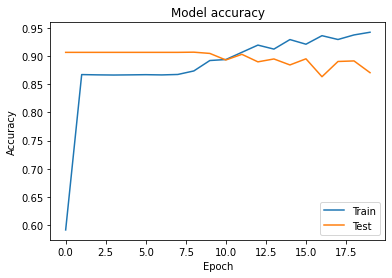

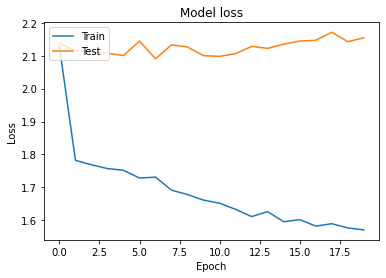

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(pred_tag,y_te_true_tag)
print(report)

TypeError: ignored

In [ ]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
  if w != 0:
      
      print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))




Sample number 21 of 25 (Test Set)
Word           ||True ||Pred
Lawyer         : O     O
:              : O     O
Ammo           : O     O
dealer         : O     O
saw            : O     O
nothing        : O     O
suspicious     : O     O
in             : O     O
Vegas          : O     O
gunman         : O     O
An             : O     O
Arizona        : O     O
man            : O     O
who            : O     O
sold           : O     O
ammunition     : O     O
to             : O     O
the            : O     O
gunman         : O     O
in             : O     O
the            : B-PROP O
deadliest      : I-PROP O
mass           : I-PROP O
shooting       : I-PROP O
in             : I-PROP O
modern         : I-PROP O
U.S.           : I-PROP O
history        : I-PROP O
was            : O     O
disturbed      : O     O
that           : O     O
he             : O     O
did            : O     O
n't            : O     O
spot           : O     O
any            : O     O
suspicious     : O     O
sign

In [ ]:
##random input testing
text_test=text

In [ ]:
print(tag2idx["O"],tag2idx["B-PROP"],tag2idx["I-PROP"])

1 3 2


In [ ]:
import spacy
nlp = spacy.blank("en") # load a new spacy model



i=0
for w, t, pred in zip(X_te[i], true, p[0]):

    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))



policies       : O     O
that           : O     O
have           : O     O
been           : O     O
implemented    : O     O
requiring      : O     O
psychological  : O     O
exams          : O     O
for            : O     O
all            : O     O
candidates     : O     O
for            : O     O
ministry       : O     O
as             : O     O
well           : O     O
as             : O     O
across         : O     O
-              : O     O
the            : O     O
-              : O     O
board          : B-PROP O
background     : I-PROP O
checks         : I-PROP O
for            : I-PROP O
anyone         : I-PROP O
working        : I-PROP O
with           : I-PROP O
children       : I-PROP O
or             : O     O
vulnerable     : O     O
individuals    : O     O
Here           : O     O
again          : O     O
I              : O     O
state          : O     O
as             : O     O
we             : O     O
have           : O     O
done           : O     O
consistently   : 

In [ ]:
# def mergespans(tokens,slabels,elabels):



def getpredspans(new_df):
  # print(new_df.shape)
  # print(new_df)

  tokens=new_df["tokens"].to_list()
  slabels=new_df["startlabels"].to_list()
  elabels=new_df["endlabels"].to_list()
  print("--start--")
  print(slabels)
  print(elabels)
  print("--end--")

  res=[[slabels[0],elabels[0]]]
  new_t=[]
  withinbuffer=[]
  finspans=[]
  final_res=[]
  res1=[]
  for token,slabel,elabel in zip(tokens[1:],slabels[1:],elabels[1:]):
    start=slabel
    end=elabel
    buffer=2
    if start-res[-1][-1]<=buffer:
      res[-1][-1]=end
      res1.append(token)
      out1=" ".join(res1)
    else:
      # print(res)
      # finspans.append([res[0][0],res[-1][-1]])

      res.append([start,end])
      # new_t.append(token)
    # final_res.append([start,end])
  return res


In [ ]:
def replace_preds(preds):

  for i in range(len(preds)):
    if preds[i]==2 or preds[i]==3:
      preds[i]=1
    elif preds[i]==1:
      preds[i]=0
  return preds

In [ ]:
from pandas.core import resample
def converttexttodf(filename,text):

  tokens=[]
  startlabels=[]
  endlabels=[]
  doc=nlp(text)
  for token in doc:
    # print(token.text, token.idx, token.idx + len(token.text) - 1)
    tokens.append(token.text)
    startlabels.append(token.idx)
    endlabels.append(token.idx + len(token.text) - 1)

  df=pd.DataFrame()
  df['tokens']=tokens
  df['startlabels']=startlabels
  df["endlabels"]=endlabels
  lst=[]
  for s in tokens:
    if s=='':
      continue
    if s not in word2idx:
      continue
    lst.append(word2idx[s])
  X_test = pad_sequences(maxlen=max_len, sequences=[lst], padding="post", value=word2idx["PAD"])
  pred = model.predict(np.array(X_test))
  predspan = np.argmax(pred, axis=-1)
  pred=predspan[0].tolist()
  print('pred',pred)
  newpreds=replace_preds(pred)
  print('n',newpreds)
  df['preds']=pd.Series(newpreds)
  # print(df.head())
  new_df=df.loc[df['preds'] == 1]
  print(new_df)
  if new_df.empty:
    print('true')
    return []

  res=getpredspans(new_df)

  return res




In [ ]:
def convertoutput(output):
  df_f=pd.DataFrame()
  cols=['filename','start','end']
  df_f[cols]=cols

  starts=[]
  ends=[]
  for i in range(len(output)):
    starts.append(output[i][0])
    ends.append(output[i][1])
  
  df_f['start']=starts
  df_f['end']=ends
  return df_f

In [ ]:
def final_convert(filename,output):
  fin=convertoutput(output)
  fin['filename']=filename
  return fin

In [ ]:
from pandas.core.missing import find_valid_index
import glob
files=glob.glob("/content/drive/MyDrive/project_5_data/datasets/dev-articles/*")

def getfinalresult(testfolder):
  final=pd.DataFrame()
  cols=['filename','start','end']
  final[cols]=cols
  for file in testfolder:
    # print(file)
    text = open(file,'r').read()
    res=converttexttodf(file[-13:-4],text)
    print('res',res)
    fin=final_convert(file[-13:-4],res)
    final=final.append(fin)
    

  return final


In [ ]:
final=getfinalresult(files)

pred [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
final ###this is the final dataframe ...convert it to tsv or csv and then compare it with dev si labels file..

,filename,start,end
0,999001419,3703,3717
0,787085939,1380,1533
1,787085939,2124,2272
2,787085939,3323,3379
3,787085939,3480,3496
...,...,...,...
1,999001280,1869,1943
2,999001280,2202,2251
3,999001280,2972,3062
4,999001280,3848,4021


In [ ]:
# #remove
# import re
# import string
# def clean_text(text):
# #will replace the html characters with " "
#   text=re.sub('<.*?>', ' ', text)  
#   #To remove the punctuations
#   text = text.translate(str.maketrans(' ',' ',string.punctuation))
#   #will consider only alphabets and numerics
#   text = re.sub('[^a-zA-Z]',' ',text)  
#   #will replace newline with space
#   text = re.sub("\n"," ",text)
#   # will split and join the words
#   text=' '.join(text.split())
#   return text

In [ ]:
final.to_csv('output_si_baseline.tsv', sep='\t', index=False,header=False)

In [ ]:
##code taken from taskscorer.py provided

__author__ = "Giovanni Da San Martino"
__copyright__ = "Copyright 2019"
__credits__ = [""]
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = ""
__email__ = "gmartino@hbku.edu.qa"
__status__ = "Beta"

import sys
import argparse
import os.path
import re
import glob
import logging.handlers

TASK_3_ARTICLE_ID_COL=0
#TASK_3_TECHNIQUE_NAME_COL=1
TASK_3_FRAGMENT_START_COL=1
TASK_3_FRAGMENT_END_COL=2
TECHNIQUE_NAMES_FILE="/content/drive/MyDrive/Colab Notebooks/project_5_data/propaganda-techniques-scorer/data/propaganda-techniques-names.txt"

logger = logging.getLogger("propaganda_scorer")
ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.setLevel(logging.INFO)


def check_data_file_lists(submission_annotations, gold_annotations, task_name="task3"):

    #checking that the number of articles for which the user has submitted annotations is correct
    if len(gold_annotations.keys()) < len(submission_annotations.keys()):
        logger.error("The number of articles in the submission, %d, is greater than the number of articles in the "
                     "reference dataset, %d." % (len(submission_annotations.keys()), len(gold_annotations.keys()))); sys.exit()
    # logger.debug("OK: number of articles in the submission for %s is the same as the one in the gold file: %d"
    #              % (task_name, len(gold_annotations.keys())))

    #check that all file names are correct
    errors = [ article_id for article_id in submission_annotations.keys() if article_id not in gold_annotations.keys() ]
    if len(errors)>0:
        logger.error("The following article_ids in the submission file do not have a correspondence in the reference "
                     "dataset: %s\n" % (str(errors)))
    # gold_file_article_id_set = set([article_id for article_id in gold_annotations.keys()])
    # submission_file_article_id_set = set([article_id for article_id in submission_annotations.keys()])
    # intersection_file_list = gold_file_article_id_set.intersection(submission_file_article_id_set)
    # if len(intersection_file_list) != len(gold_annotations):
    #     logger.error("The list of article ids is not identical.\n"
    #              "The following article_ids in the submission file do not have a correspondence in the gold file: %s\n"
    #              "The following article_ids in the gold file do not have a correspondence in the submission file: %s"
    #              %(str(submission_file_article_id_set.difference(gold_file_article_id_set)),
    #                str(gold_file_article_id_set.difference(submission_file_article_id_set)))); sys.exit()
    logger.debug("OK: all article ids have a correspondence in the list of articles from the reference dataset")


def load_technique_names_from_file(filename=TECHNIQUE_NAMES_FILE):

    with open(filename, "r") as f:
        return [ line.rstrip() for line in f.readlines() ]


def extract_article_id_from_file_name(fullpathfilename):

    regex = re.compile("article([0-9]+).*")
    return regex.match(os.path.basename(fullpathfilename)).group(1)


def print_annotations(annotation_list):
    s = ""
    i=0
    for technique, span in annotation_list:
        s += "%d) %s: %d - %d\n"%(i, technique, min(span), max(span))
        i += 1
    return s

def merge_spans(annotations_without_overlapping, i):
    """

    :param spans: a list of spans of article annotations
    :param i: the index in spans which needs to be tested for ovelapping
    :param annotations: a list of annotations of an article
    :return:
    """
    #print("checking element %d of %d"%(i, len(spans)))
    for j in range(0, len(annotations_without_overlapping)):
        assert i<len(annotations_without_overlapping) or print(i, len(annotations_without_overlapping))
        if j != i and len(annotations_without_overlapping[i][1].intersection(annotations_without_overlapping[j][1])) > 0:
            # print("Found overlapping spans: %d-%d and %d-%d in annotations %d,%d:\n%s"
            #       %(min(annotations_without_overlapping[i][1]), max(annotations_without_overlapping[i][1]),
            #         min(annotations_without_overlapping[j][1]), max(annotations_without_overlapping[j][1]), i,j,
            #         print_annotations(annotations_without_overlapping)))
            annotations_without_overlapping[j][1] = annotations_without_overlapping[j][1].union(annotations_without_overlapping[i][1])
            del(annotations_without_overlapping[i])
            # print("Annotations after deletion:\n%s"%(print_annotations(annotations_without_overlapping)))
            if j > i:
                j -= 1
            # print("calling recursively")
            merge_spans(annotations_without_overlapping, j)
            # print("done")
            return True

    return False


def check_annotation_spans(annotations, merge_overlapping_spans=False):

    for article_id in annotations.keys():  # for each article
        #print(article_id)
        spans = []
        annotations_without_overlapping = []
        for annotation in annotations[article_id]:
            if merge_overlapping_spans:
                #spans.append(annotation[1])
                annotations_without_overlapping.append([annotation[0], annotation[1]])
                #if merge_spans(spans, len(spans)-1, annotations[article_id]):
                merge_spans(annotations_without_overlapping, len(annotations_without_overlapping) - 1)
                #if merge_spans(annotations_without_overlapping, len(annotations_without_overlapping) - 1):
                #    print("Done with merging:\n" + print_annotations(annotations_without_overlapping))
            else:
                for span in spans:
                    if len(span.intersection(annotation[1])) > 0:
                        logger.error("In article %s, the span [%s,%s] overlap with the following one from the same "
                                     "article: [%s,%s]" % (article_id, min(annotation[1]), max(annotation[1]),
                                                           min(span), max(span)))
                        return False
                spans.append(annotation[1])
        if merge_overlapping_spans:
            annotations[article_id] = annotations_without_overlapping
    return True


def check_annotation_spans_with_category_matching(annotations, merge_overlapping_spans=False):
    """
    Check whether there are ovelapping spans for the same technique in the same article.
    Two spans are overlapping if their associated techniques match (according to category_matching_func)
    If merge_overlapping_spans==True then the overlapping spans are merged, otherwise an error is raised.

    :param annotations: a dictionary with the full set of annotations for all articles
    :param merge_overlapping_spans: if True merges the overlapping spans
    :return:
    """

    for article_id in annotations.keys():  # for each article

        annotation_list = {}
        for technique, curr_span in annotations[article_id]:
            if technique not in annotation_list.keys():
                annotation_list[technique] = [ [technique, curr_span] ]
            else:
                if merge_overlapping_spans:
                    annotation_list[technique].append([technique, curr_span])
                    merge_spans(annotation_list[technique], len(annotation_list[technique]) - 1)
                else:
                    for matching_technique, span in annotation_list[technique]:
                        if len(curr_span.intersection(span)) > 0:
                            logger.error("In article %s, the span of the annotation %s, [%s,%s] overlap with "
                                         "the following one from the same article:%s, [%s,%s]" % (article_id, matching_technique,
                                                                min(span), max(span), technique, min(curr_span), max(curr_span)))
                            return False
                    annotation_list[technique].append([technique, curr_span])
        if merge_overlapping_spans:
            annotations[article_id] = []
            for technique in annotation_list.keys():
                annotations[article_id] += annotation_list[technique]
    return True


def check_format_of_annotation_in_file(row, i, techniques_names, filename):
    """

    :param row: a list of fields describing the annotation elements (technique name, start_span, end_span)
    :param i:
    :return:
    """

    if len(row) != 3:
        logger.error("Row %d in file %s is supposed to have 3 TAB-separated columns. Found %d."
                     % (i + 1, filename, len(row)))
        sys.exit()
    # checking the technique names are correct
    # if row[TASK_3_TECHNIQUE_NAME_COL] not in techniques_names:
    #     logger.error("On row %d in file %s the technique name, %s, is incorrect. Possible values are: %s"
    #                  % (i + 1, filename, row[TASK_3_TECHNIQUE_NAME_COL], str(techniques_names)))
    #     sys.exit()
    # checking spans
    if int(row[TASK_3_FRAGMENT_START_COL]) < 0 or int(row[TASK_3_FRAGMENT_END_COL]) < 0:
        logger.error("On row %d in file %s, start and end of position of the fragment must be non-negative. "
                     "Found values %s, %s" % (i + 1, filename, row[TASK_3_FRAGMENT_START_COL], row[TASK_3_FRAGMENT_END_COL]))
        sys.exit()
    if int(row[TASK_3_FRAGMENT_START_COL]) >= int(row[TASK_3_FRAGMENT_END_COL]):
        logger.error("On row %d in file %s, end position of the fragment must be greater than the starting "
                     "one. Found values %s, %s" % (i + 1, filename, row[TASK_3_FRAGMENT_START_COL], row[TASK_3_FRAGMENT_END_COL]))
        sys.exit()


def check_article_annotations_format(submission_article_annotations, article_id, techniques_names):

    annotations = {}
    for i, row in enumerate(submission_article_annotations):
        check_annotation_format_from_file(row, i)
        #checking that there are no overlapping spans flagged with the same technique name
        if row[0] not in annotations.keys():
            annotations[row[0]] = []
        else:
            curr_span = set(range(int(row[1]), int(row[2])))
            for span in annotations[row[0]]:
                if len(set(range(int(span[0]), int(span[1]))).intersection(curr_span)) > 0:
                    logger.error("On row %d in article %s, the span of the annotation %s, [%s,%s] overlap with the "
                                 "following one from the same file: [%s,%s]"
                                 % (i + 1, article_id, row[0], row[1], row[2], span[0], span[1]));
                    sys.exit()
        annotations[row[0]].append([row[1], row[2]])
    logger.debug("OK: article %s format is correct" % (article_id))


def read_task3_output_file(filename):

    with open(filename, "r") as f:
        return [ line.rstrip().split("\t") for line in f.readlines() ]


def compute_technique_frequency(annotations_list, technique_name):
    return sum([ len([ example_annotation for example_annotation in x if example_annotation[0]==technique_name])
                 for x in annotations_list ])


def compute_score_max(submission_annotations, gold_annotations, technique_names, prop_vs_non_propaganda=False):

    prec_denominator = sum([len(annotations) for annotations in submission_annotations.values()])
    rec_denominator = sum([len(annotations) for annotations in gold_annotations.values()])
    technique_Spr_max = {propaganda_technique: 0 for propaganda_technique in technique_names}
    cumulative_Spr_max = 0
    for article_id in submission_annotations.keys():
        gold_data = gold_annotations[article_id]
        logger.debug("Computing contribution to the score of article id %s\nand tuples %s\n%s\n"
                     % (article_id, str(submission_annotations[article_id]), str(gold_data)))
        for j, sd in enumerate(submission_annotations[article_id]): #submission_data:
            s=""
            sd_annotation_length = len(sd[1])
            for i, gd in enumerate(gold_data):
                if prop_vs_non_propaganda or gd[0]==sd[0]:
                    #s += "\tmatch %s %s-%s - %s %s-%s"%(sd[0],sd[1], sd[2], gd[0], gd[1], gd[2])
                    intersection = len(sd[1].intersection(gd[1]))
                    gd_annotation_length = len(gd[1])

                    Spr = intersection/max(sd_annotation_length, gd_annotation_length)
                    cumulative_Spr_max += Spr
                    s += "\tmatch %s %s-%s - %s %s-%s: S(p,r)=|intersect(r, p)|/max(|p|,|r|) = %d/max(%d,%d) = %f (cumulative S(p,r)=%f)\n"\
                         %(sd[0],min(sd[1]), max(sd[1]), gd[0], min(gd[1]), max(gd[1]), intersection, sd_annotation_length, gd_annotation_length, Spr, cumulative_Spr_max)
                    technique_Spr_max[gd[0]] += Spr

            logger.debug("\n%s"%(s))

    p,r,f1 = compute_prec_rec_f1(cumulative_Spr_max, prec_denominator, cumulative_Spr_max, rec_denominator)

    if not prop_vs_non_propaganda:
        for technique_name in cumulative_Spr_max.keys():
            prec_tech, rec_tech, f1_tech = compute_prec_rec_f1(cumulative_Spr_max[technique_name],
                                        compute_technique_frequency(submission_annotations.values(), technique_name),
                                        cumulative_Spr_max[technique_name],
                                        compute_technique_frequency(gold_annotations.values(), technique_name), False)
            logger.info("%s: P=%f R=%f F1=%f" % (technique_name, prec_tech, rec_tech, f1_tech))

    # p,r,f1=(0,0,0)
    # if prec_denominator>0:
    #     p = cumulative_Spr_max/prec_denominator
    # if rec_denominator>0:
    #     r = cumulative_Spr_max/rec_denominator
    # logger.info("Precision=%f/%d=%f\tRecall=%f/%d=%f"
    #              %(cumulative_Spr_max, prec_denominator, p, cumulative_Spr_max, rec_denominator, r))
    # if prec_denominator == 0 and rec_denominator == 0:
    #     f1 = 1.0
    # if p>0 and r>0:
    #     f1 = 2*(p*r/(p+r))
    # logger.info("F1=%f"%(f1))
    #
    # if not prop_vs_non_propaganda:
    #     for technique_name in technique_Spr_max.keys():
    #         prec_tech, rec_tech, f1_tech = (0,0,0)
    #         prec_tech_denominator = compute_technique_frequency(submission_annotations.values(), technique_name)
    #         rec_tech_denominator = compute_technique_frequency(gold_annotations.values(), technique_name)
    #         if prec_tech_denominator == 0 and rec_tech_denominator == 0: #
    #             f1_tech = 1.0
    #         else:
    #             if prec_tech_denominator > 0:
    #                 prec_tech = technique_Spr_max[technique_name] / prec_tech_denominator
    #             if rec_tech_denominator > 0:
    #                 rec_tech = technique_Spr_max[technique_name] / rec_tech_denominator
    #             if prec_tech>0 and rec_tech>0:
    #                 f1_tech = 2*(prec_tech*rec_tech/(prec_tech+rec_tech))
    #         logger.info("%s: P=%f R=%f F1=%f"%(technique_name, prec_tech, rec_tech, f1_tech))

    return f1

def compute_score_min(submission_annotations, gold_annotations, technique_names, prop_vs_non_propaganda=False):

    prec_denominator = sum([len(annotations) for annotations in submission_annotations.values()])
    rec_denominator = sum([len(annotations) for annotations in gold_annotations.values()])
    technique_Spr_min = {propaganda_technique: 0 for propaganda_technique in technique_names}
    cumulative_Spr_min = 0
    for article_id in submission_annotations.keys():
        gold_data = gold_annotations[article_id]
        logger.debug("Computing contribution to the score of article id %s\nand tuples %s\n%s\n"
                     % (article_id, str(submission_annotations[article_id]), str(gold_data)))
        for j, sd in enumerate(submission_annotations[article_id]): #submission_data:
            s=""
            sd_annotation_length = len(sd[1])
            for i, gd in enumerate(gold_data):
                if prop_vs_non_propaganda or gd[0]==sd[0]:
                    #s += "\tmatch %s %s-%s - %s %s-%s"%(sd[0],sd[1], sd[2], gd[0], gd[1], gd[2])
                    intersection = len(sd[1].intersection(gd[1]))
                    gd_annotation_length = len(gd[1])

                    Spr = intersection/min(sd_annotation_length, gd_annotation_length)
                    cumulative_Spr_min += Spr
                    s += "\tmatch %s %s-%s - %s %s-%s: S(p,r)=|intersect(r, p)|/min(|p|,|r|) = %d/min(%d,%d) = %f (cumulative S(p,r)=%f)\n"\
                         %(sd[0],min(sd[1]), max(sd[1]), gd[0], min(gd[1]), max(gd[1]), intersection, sd_annotation_length, gd_annotation_length, Spr, cumulative_Spr_min)
                    technique_Spr_min[gd[0]] += Spr

            logger.debug("\n%s"%(s))

    p,r,f1 = compute_prec_rec_f1(cumulative_Spr_min, prec_denominator, cumulative_Spr_min, rec_denominator)

    if not prop_vs_non_propaganda:
        for technique_name in cumulative_Spr_min.keys():
            prec_tech, rec_tech, f1_tech = compute_prec_rec_f1(cumulative_Spr_min[technique_name],
                                        compute_technique_frequency(submission_annotations.values(), technique_name),
                                        cumulative_Spr_min[technique_name],
                                        compute_technique_frequency(gold_annotations.values(), technique_name), False)
            logger.info("%s: P=%f R=%f F1=%f" % (technique_name, prec_tech, rec_tech, f1_tech))

    # p,r,f1=(0,0,0)
    # if prec_denominator>0:
    #     p = cumulative_Spr_min/prec_denominator
    # if rec_denominator>0:
    #     r = cumulative_Spr_min/rec_denominator
    # logger.info("Precision=%f/%d=%f\tRecall=%f/%d=%f"
    #              %(cumulative_Spr_min, prec_denominator, p, cumulative_Spr_min, rec_denominator, r))
    # if prec_denominator == 0 and rec_denominator == 0:
    #     f1 = 1.0
    # if p>0 and r>0:
    #     f1 = 2*(p*r/(p+r))
    # logger.info("F1=%f"%(f1))
    #
    # if not prop_vs_non_propaganda:
    #     for technique_name in technique_Spr_min.keys():
    #         prec_tech, rec_tech, f1_tech = (0,0,0)
    #         prec_tech_denominator = compute_technique_frequency(submission_annotations.values(), technique_name)
    #         rec_tech_denominator = compute_technique_frequency(gold_annotations.values(), technique_name)
    #         if prec_tech_denominator == 0 and rec_tech_denominator == 0: #
    #             f1_tech = 1.0
    #         else:
    #             if prec_tech_denominator > 0:
    #                 prec_tech = technique_Spr_min[technique_name] / prec_tech_denominator
    #             if rec_tech_denominator > 0:
    #                 rec_tech = technique_Spr_min[technique_name] / rec_tech_denominator
    #             if prec_tech>0 and rec_tech>0:
    #                 f1_tech = 2*(prec_tech*rec_tech/(prec_tech+rec_tech))
    #         logger.info("%s: P=%f R=%f F1=%f"%(technique_name, prec_tech, rec_tech, f1_tech))

    return f1


def compute_score_pr(submission_annotations, gold_annotations, technique_names, prop_vs_non_propaganda=False,
                     per_article_evaluation=False, output_for_script=False):

    prec_denominator = sum([len(annotations) for annotations in submission_annotations.values()])
    rec_denominator = sum([len(annotations) for annotations in gold_annotations.values()])
    technique_Spr_prec = {propaganda_technique: 0 for propaganda_technique in technique_names}
    technique_Spr_rec = {propaganda_technique: 0 for propaganda_technique in technique_names}
    cumulative_Spr_prec, cumulative_Spr_rec = (0, 0)
    f1_articles = []

    for article_id in submission_annotations.keys():
        gold_data = gold_annotations[article_id]
        logger.debug("Computing contribution to the score of article id %s\nand tuples %s\n%s\n"
                     % (article_id, str(submission_annotations[article_id]), str(gold_data)))

        article_cumulative_Spr_prec, article_cumulative_Spr_rec = (0, 0)
        for j, sd in enumerate(submission_annotations[article_id]): #submission annotations for article article_id:
            s=""
            sd_annotation_length = len(sd[1])
            for i, gd in enumerate(gold_data):
                if prop_vs_non_propaganda or gd[0]==sd[0]:
                    #s += "\tmatch %s %s-%s - %s %s-%s"%(sd[0],sd[1], sd[2], gd[0], gd[1], gd[2])
                    intersection = len(sd[1].intersection(gd[1]))
                    gd_annotation_length = len(gd[1])
                    Spr_prec = intersection/sd_annotation_length
                    article_cumulative_Spr_prec += Spr_prec
                    cumulative_Spr_prec += Spr_prec
                    s += "\tmatch %s %s-%s - %s %s-%s: S(p,r)=|intersect(r, p)|/|p| = %d/%d = %f (cumulative S(p,r)=%f)\n"\
                         %(sd[0],min(sd[1]), max(sd[1]), gd[0], min(gd[1]), max(gd[1]), intersection, sd_annotation_length, Spr_prec, cumulative_Spr_prec)
                    technique_Spr_prec[gd[0]] += Spr_prec

                    Spr_rec = intersection/gd_annotation_length
                    article_cumulative_Spr_rec += Spr_rec
                    cumulative_Spr_rec += Spr_rec
                    s += "\tmatch %s %s-%s - %s %s-%s: S(p,r)=|intersect(r, p)|/|r| = %d/%d = %f (cumulative S(p,r)=%f)\n"\
                         %(sd[0],min(sd[1]), max(sd[1]), gd[0], min(gd[1]), max(gd[1]), intersection, gd_annotation_length, Spr_rec, cumulative_Spr_rec)
                    technique_Spr_rec[gd[0]] += Spr_rec
            logger.debug("\n%s"%(s))

        p_article, r_article, f1_article =compute_prec_rec_f1(article_cumulative_Spr_prec,
                                                              len(submission_annotations[article_id]),
                                                              article_cumulative_Spr_rec,
                                                              len(gold_annotations[article_id]), False)
        f1_articles.append(f1_article)

    p,r,f1 = compute_prec_rec_f1(cumulative_Spr_prec, prec_denominator, cumulative_Spr_rec, rec_denominator)
    out = ""
    if output_for_script:
        out += "%f\t%f\t%f"%(f1,p,r) 
    if not prop_vs_non_propaganda:
        for technique_name in technique_names:
            prec_tech, rec_tech, f1_tech = compute_prec_rec_f1(technique_Spr_prec[technique_name],
                                        compute_technique_frequency(submission_annotations.values(), technique_name),
                                        technique_Spr_prec[technique_name],
                                        compute_technique_frequency(gold_annotations.values(), technique_name), False)
            logger.info("%s: P=%f R=%f F1=%f" % (technique_name, prec_tech, rec_tech, f1_tech))
            if output_for_script:
                f1_str = str(f1_tech)
                if len(f1_str) > 1:
                    out += "\t" + f1_str.rstrip("0").rstrip(".")
                else:
                    out += "\t" + f1_str
    if output_for_script:
        print(out)
    if per_article_evaluation:
        logger.info("Per article evaluation F1=%s"%(",".join([ str(f1_value) for f1_value in  f1_articles])))

    return f1


def compute_prec_rec_f1(prec_numerator, prec_denominator, rec_numerator, rec_denominator, print_results=True):

    logger.debug("P=%f/%d, R=%f/%d"%(prec_numerator, prec_denominator, rec_numerator, rec_denominator))
    p, r, f1 = (0, 0, 0)
    if prec_denominator > 0:
        p = prec_numerator / prec_denominator
    if rec_denominator > 0:
        r = rec_numerator / rec_denominator
    if print_results: logger.info("Precision=%f/%d=%f\tRecall=%f/%d=%f" % (prec_numerator, prec_denominator, p,
                                                                           rec_numerator, rec_denominator, r))
    if prec_denominator == 0 and rec_denominator == 0:
        f1 = 1.0
    if p > 0 and r > 0:
        f1 = 2 * (p * r / (p + r))
    if print_results:
        logger.info("F1=%f" % (f1))
    return p,r,f1


def load_annotation_list_from_folder(folder_name, techniques_names):

    file_list = glob.glob(os.path.join(folder_name, "*.labels"))
    if len(file_list)==0:
        logger.error("Cannot load file list in folder " + folder_name);
        sys.exit()
    annotations = {}
    for filename in file_list:
        annotations[extract_article_id_from_file_name(filename)] = []
        with open(filename, "r") as f:
            for row_number, line in enumerate(f.readlines()):
                row = line.rstrip().split("\t")
                check_format_of_annotation_in_file(row, row_number, techniques_names, filename)
                # annotations[row[TASK_3_ARTICLE_ID_COL]].append([ row[TASK_3_TECHNIQUE_NAME_COL],
                #                                                  row[TASK_3_FRAGMENT_START_COL],
                #                                                  row[TASK_3_FRAGMENT_END_COL] ])
                annotations[row[TASK_3_ARTICLE_ID_COL]].append(["propaganda",
                                                                set(range(int(row[TASK_3_FRAGMENT_START_COL]),
                                                                          int(row[TASK_3_FRAGMENT_END_COL])))])
    return annotations


def load_annotation_list_from_file(filename, techniques_names):

    annotations = {}
    with open(filename, "r") as f:
        for row_number, line in enumerate(f.readlines()):
            row = line.rstrip().split("\t")
            check_format_of_annotation_in_file(row, row_number, techniques_names, filename)
            if row[TASK_3_ARTICLE_ID_COL] not in annotations.keys():
                annotations[row[TASK_3_ARTICLE_ID_COL]] = []
            # annotations[row[TASK_3_ARTICLE_ID_COL]].append([ row[TASK_3_TECHNIQUE_NAME_COL],
            #                                                  row[TASK_3_FRAGMENT_START_COL],
            #                                                  row[TASK_3_FRAGMENT_END_COL]])
            annotations[row[TASK_3_ARTICLE_ID_COL]].append([ "propaganda",
                                                             set(range(int(row[TASK_3_FRAGMENT_START_COL]),
                                                                       int(row[TASK_3_FRAGMENT_END_COL]))) ])
    return annotations


def main():

    # user_submission_file = '/content/drive/MyDrive/Colab Notebooks/project_5_data/propaganda-techniques-scorer/data/dev-task-SI.labels'#args.submission

    user_submission_file="/content/output_si_baseline.tsv"
    gold_folder = '/content/drive/MyDrive/project_5_data/datasets/dev-task-si.labels'#args.gold
    #output_log_file = #args.log_file
    prop_vs_non_propaganda = True
    merge_user_annotations = False #bool(args.merge_user_annotations)
    per_article_evaluation = False
    output_for_script = False #bool(args.output_for_script)  

    if not output_for_script:
        logger.addHandler(ch)

    # if args.debug_on_std:
    #     ch.setLevel(logging.DEBUG)

    # if output_log_file is not None:
    #     logger.info("Logging execution to file " + output_log_file)
    #     fileLogger = logging.FileHandler(output_log_file)
    #     fileLogger.setLevel(logging.DEBUG)
    #     fileLogger.setFormatter(formatter)
    #     logger.addHandler(fileLogger)

    techniques_names = [ "propaganda" ] #load_technique_names_from_file(args.techniques_file)
    submission_annotations = load_annotation_list_from_file(user_submission_file, techniques_names)
    logger.info('Checking user submitted file')
    #gold_annotations = load_annotation_list_from_folder(gold_folder, techniques_names)
    gold_annotations = load_annotation_list_from_file(gold_folder, techniques_names)
    check_data_file_lists(submission_annotations, gold_annotations)
    if not check_annotation_spans(submission_annotations, merge_user_annotations):
        logger.info("Error in submission file")
        sys.exit()
    check_annotation_spans(gold_annotations, True)

    logger.info("Scoring the submission with precision and recall method")
    score_pr = compute_score_pr(submission_annotations, gold_annotations, techniques_names,
                                prop_vs_non_propaganda, per_article_evaluation, output_for_script)
    return score_pr


if __name__ == "__main__":

    # parser = argparse.ArgumentParser("Scorer for Task SI on the Propaganda Techniques Corpus. ")
    # # parser.add_argument('-s', '--submission-file', dest='submission', required=True, help="file with the submission of the team")
    # # parser.add_argument('-r', '--reference-folder', dest='gold', required=True, help="folder with the gold labels.")
    # parser.add_argument('-d', '--enable-debug-on-standard-output', dest='debug_on_std', required=False,
    #                     action='store_true', help="Print debug info also on standard output.")
    # parser.add_argument('-l', '--log-file', dest='log_file', required=False, help="Output logger file.")
    # parser.add_argument('-m', '--merge-user-annotations', dest='merge_user_annotations', required=False, action='store_true',
    #                     default=False, help="If the option is added, overlapping user annotations are merged")
    # parser.add_argument('-o', '--output-for-script', dest='output_for_script', required=False, action='store_true',
    #                     default=False, help="Prints the output in an easy-to-parse way for a script")
    # main(parser.parse_args())
    main()

2022-05-05 01:56:36,143 - INFO - Checking user submitted file
2022-05-05 01:56:36,143 - INFO - Checking user submitted file
2022-05-05 01:56:36,143 - INFO - Checking user submitted file
2022-05-05 01:56:36,143 - INFO - Checking user submitted file
2022-05-05 01:56:36,175 - INFO - Scoring the submission with precision and recall method
2022-05-05 01:56:36,175 - INFO - Scoring the submission with precision and recall method
2022-05-05 01:56:36,175 - INFO - Scoring the submission with precision and recall method
2022-05-05 01:56:36,175 - INFO - Scoring the submission with precision and recall method
2022-05-05 01:56:36,280 - INFO - Precision=26.916581/298=0.090324	Recall=56.673620/940=0.060291
2022-05-05 01:56:36,280 - INFO - Precision=26.916581/298=0.090324	Recall=56.673620/940=0.060291
2022-05-05 01:56:36,280 - INFO - Precision=26.916581/298=0.090324	Recall=56.673620/940=0.060291
2022-05-05 01:56:36,280 - INFO - Precision=26.916581/298=0.090324	Recall=56.673620/940=0.060291
2022-05-05 0